In [1]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image, display
from scipy.signal import hilbert
import librosa.display
import librosa.feature
import IPython.display as ipd
from scipy.signal import butter, filtfilt

# Basic audio features

- Code inspired from: https://github.com/musikalkemist/AudioSignalProcessingForML
- Accompanying videos: https://www.youtube.com/watch?v=iCwMQJnKk2c&list=PL-wATfeyAMNqIee7cH3q1bh4QJFAaeNv0&ab_channel=ValerioVelardo-TheSoundofAI
- The audio files are high-quality textbook examples heart sounds from [Michigan University](https://deepblue.lib.umich.edu/handle/2027.42/120554) (fortunately rescued by deepblue!).

## Loading audio files

We start by loading some heart sounds:

In [2]:
# load audio files with librosa

DURATION = 2.0 # seconds
OFFSET = 1.0 # seconds

normal_file = "assets/heart_sounds/01_apex_normal_s1_s2_supine_bell.mp3"
s2_split_file = "assets/heart_sounds/19_pulm_spilt_s2_persistent_supine_diaph.mp3"
s3_file = "assets/heart_sounds/05_apex_s3_lld_bell.mp3"
mid_syst_click_file = "assets/heart_sounds/04_apex_mid_sys_click_supine_bell.mp3"
mid_syst_murmur_file = "assets/heart_sounds/07_apex_mid_sys_mur_supine_bell.mp3"

normal, sr = librosa.load(normal_file, offset = OFFSET, duration = DURATION)
s2_split, sr = librosa.load(s2_split_file, offset = OFFSET, duration = DURATION)
s3, sr = librosa.load(s3_file, offset = OFFSET, duration = DURATION)
mid_syst_click, sr = librosa.load(mid_syst_click_file, offset = OFFSET, duration = DURATION)
mid_syst_murmur, sr = librosa.load(mid_syst_murmur_file, offset = OFFSET, duration = DURATION)

print(f"Original sampling rate: {sr} Hz")

Original sampling rate: 22050 Hz


In [3]:
# We normalize the signals

normal = librosa.util.normalize(normal)
s2_split = librosa.util.normalize(s2_split)
s3 = librosa.util.normalize(s3)
mid_syst_click = librosa.util.normalize(mid_syst_click)
mid_syst_murmur = librosa.util.normalize(mid_syst_murmur)

In [4]:
# Duration of the audio file

tot_samples = len(normal)
duration = 1 / sr * tot_samples
print(f"The audio lasts for {duration} seconds")

The audio lasts for 2.0 seconds


Each chosen heart sound has specific features characteristic of a condition (or lack of):

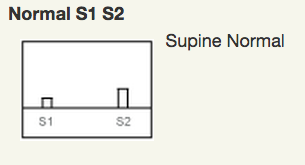

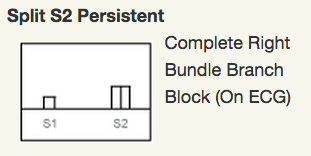

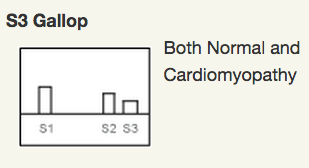

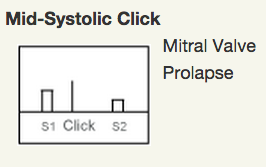

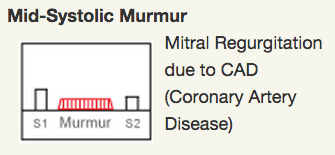

In [5]:
display(Image("assets/figures/aortic-normal_s1_s2.png"))
display(ipd.Audio(data=normal, rate=sr))
display(Image("assets/figures/pulmonic-ejection_systolic_murmur_with_transient_splitting_s2.png"))
display(ipd.Audio(data=s2_split, rate=sr))
display(Image("assets/figures/s3_gallop.png"))
display(ipd.Audio(data=s3, rate=sr))
display(Image("assets/figures/mid-systolic-click_mitral_valve_prolapse.png"))
display(ipd.Audio(data=mid_syst_click, rate=sr))
display(Image("assets/figures/mid-systolic-murmur.png"))
display(ipd.Audio(data=mid_syst_murmur, rate=sr))

## Resampling

Heart sounds have frequencies covering 15-1kHz range.
Resampling will lower the dimension of the data and help the model.

Choosing a Nyquist frequency of 1024 Hz, we resample with twice this frequency.

In [6]:
low_sr = 2048

# Note that an antialiasing filter is automatically applied
normal_resampled = librosa.resample(normal, orig_sr=sr, target_sr=low_sr, res_type="soxr_vhq")
s2_split_resampled = librosa.resample(s2_split, orig_sr=sr, target_sr=low_sr, res_type="soxr_vhq")
s3_resampled = librosa.resample(s3, orig_sr=sr, target_sr=low_sr, res_type="soxr_vhq")
mid_syst_click_resampled = librosa.resample(mid_syst_click, orig_sr=sr, target_sr=low_sr, res_type="soxr_vhq")
mid_syst_murmur_resampled = librosa.resample(mid_syst_murmur, orig_sr=sr, target_sr=low_sr, res_type="soxr_vhq")

We listen to the resampled audio files just to make sure that we did not introduce any aliasing:

In [7]:
# Web browsers won't play audio with a rate under 3kHz.
# Just for the sake of playing the downsampled files, we upsample to the minimum allowed sr.

DUMMY_SR = 3000

normal_resampled_2 = librosa.resample(normal_resampled, orig_sr=low_sr, target_sr=DUMMY_SR)
s2_split_resampled_2 = librosa.resample(s2_split_resampled, orig_sr=low_sr, target_sr=DUMMY_SR)
s3_resampled_2 = librosa.resample(s3_resampled, orig_sr=low_sr, target_sr=DUMMY_SR)
mid_syst_click_resampled_2 = librosa.resample(mid_syst_click_resampled, orig_sr=low_sr, target_sr=DUMMY_SR)
mid_syst_murmur_resampled_2 = librosa.resample(mid_syst_murmur_resampled, orig_sr=low_sr, target_sr=DUMMY_SR)
display(ipd.Audio(data=normal_resampled_2, rate=DUMMY_SR))
display(ipd.Audio(data=s2_split_resampled_2, rate=DUMMY_SR))
display(ipd.Audio(data=s3_resampled_2, rate=DUMMY_SR))
display(ipd.Audio(data=mid_syst_click_resampled_2, rate=DUMMY_SR))
display(ipd.Audio(data=mid_syst_murmur_resampled_2, rate=DUMMY_SR))

We can also look at the waveform to check that we are not loosing any important details:

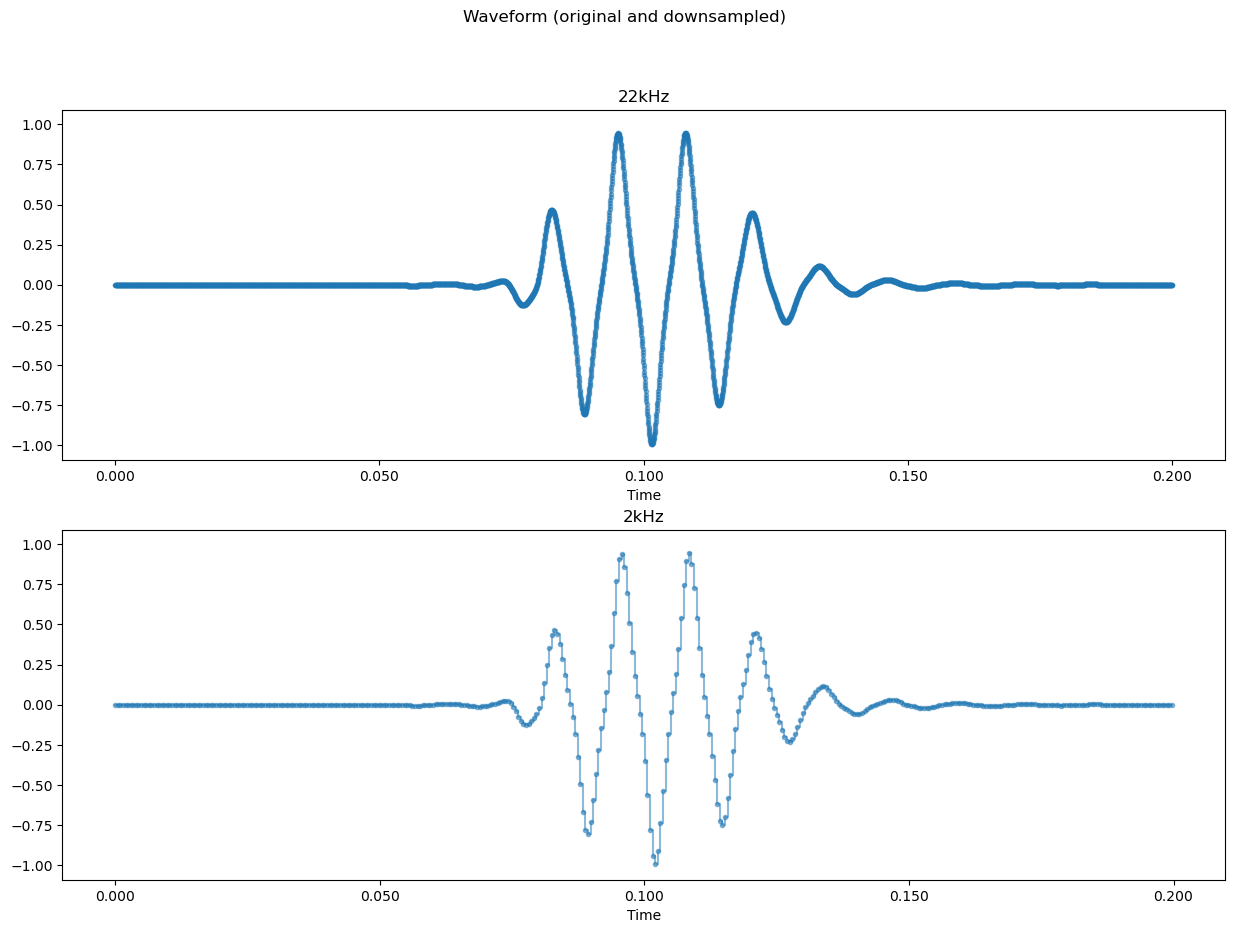

In [8]:
def plot_original_and_downsampled(signal, signal_resampled, start_ratio=0, end_ratio=1):
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 1, 1)
    librosa.display.waveshow(signal[int(len(signal)*start_ratio):int(len(signal)*end_ratio)], sr=sr, alpha=0.5, marker=".")
    plt.title("22kHz")

    plt.subplot(2, 1, 2)
    librosa.display.waveshow(signal_resampled[int(len(signal_resampled)*start_ratio):int(len(signal_resampled)*end_ratio)], sr=low_sr, alpha=0.5, marker=".")
    plt.title("2kHz")

    plt.suptitle("Waveform (original and downsampled)")
    plt.show()

plot_original_and_downsampled(normal, normal_resampled, 0.02, 0.12)

## Waveform

Let us look at the waveform of some common heart sounds:

In [9]:
def plot_waveform(signal, title, start_ratio=0, end_ratio=1):
    plt.figure(figsize=(15, 5))
    librosa.display.waveshow(signal[int(len(signal)*start_ratio):int(len(signal)*end_ratio)], sr=low_sr, alpha=0.5, marker=".")
    plt.title(title)

### Normal S1 S2

- The length of S1 and S2 is about 80ms. Assuming this is a typical heart sound, we should aim to have a time resolution < 50ms.
- S1 and S2 have the same frequency, but S1 has larger amplitude than S2.

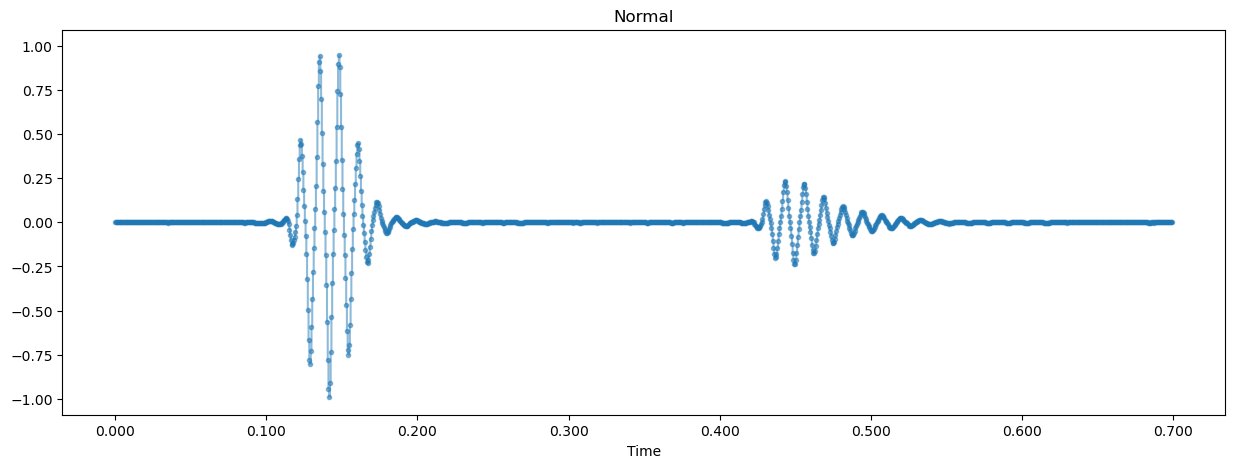

In [10]:
plot_waveform(normal_resampled, "Normal", 0, 0.35)

### Split S2

The delay between the two sounds forming S2 is about 60ms. To be able to detect this feature, a resolution of about 30ms seems indicated. Note that the second S2 sound has the same frequency as the first S2.

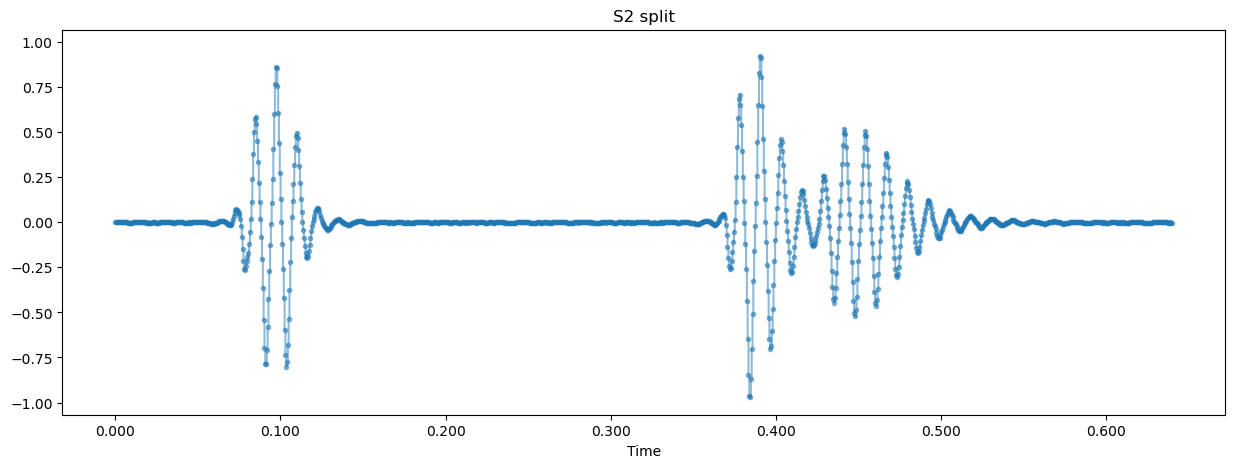

In [11]:
plot_waveform(s2_split_resampled, "S2 split", 0.28, 0.6)

### S3

S3 has lower amplitude and frequency than S2. It would be similar with S4.

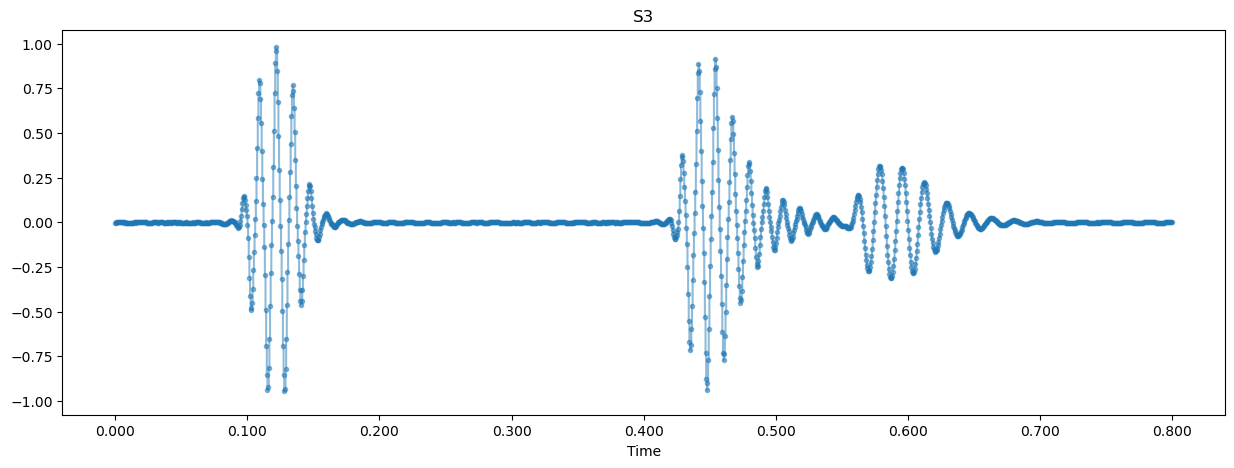

In [12]:
plot_waveform(s3_resampled, "S3", 0.05, 0.45)

### Mid systolic click

The systolic click (at 200ms) looks different from a split S2: it has a higher and irregular frequency. It also has a shorter duration and lower amplitude than S1.

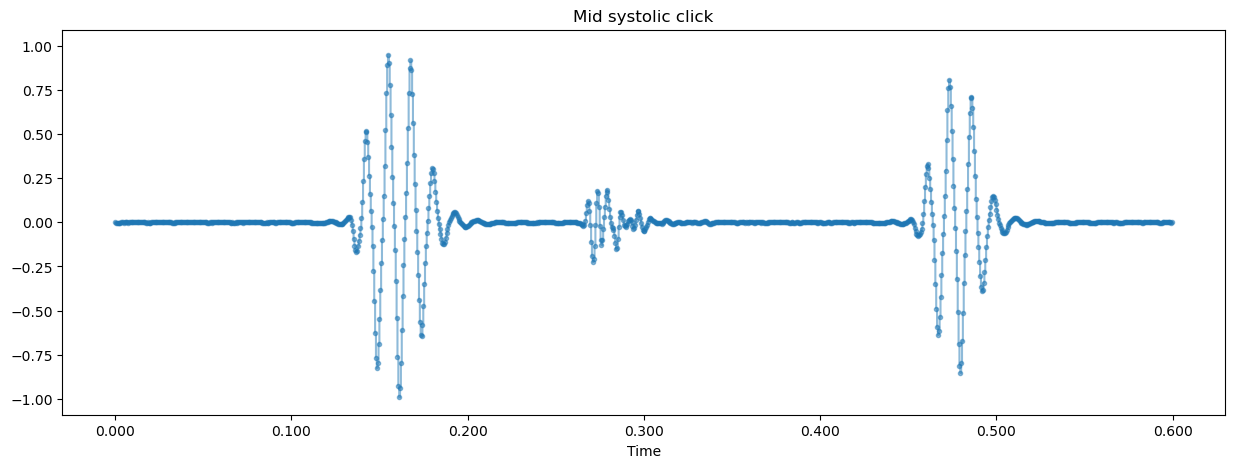

In [13]:
plot_waveform(mid_syst_click_resampled, "Mid systolic click", 0.1, 0.4)

### Mid systolic murmur

Note that the sinusoid in the diastole is noise.

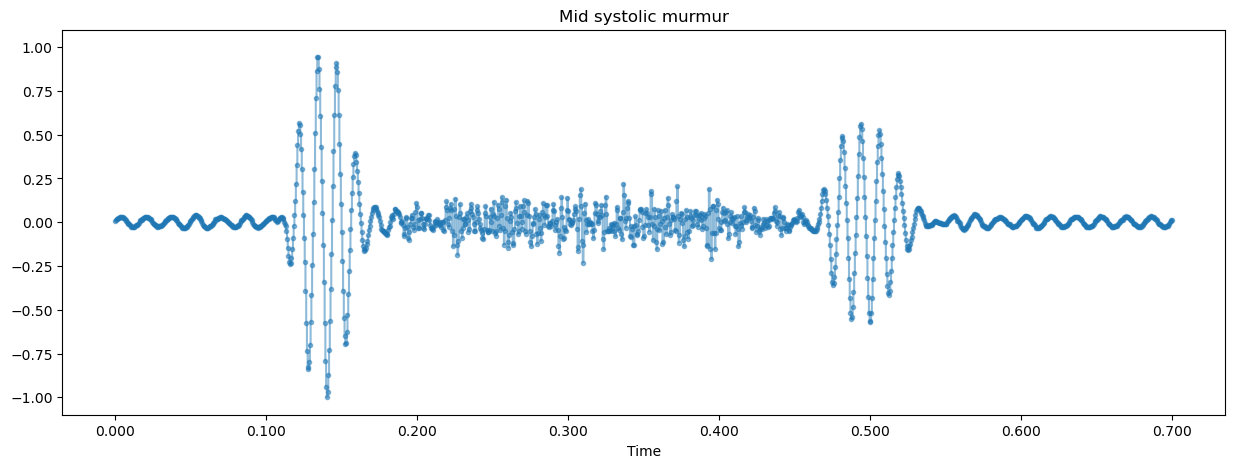

In [14]:
plot_waveform(mid_syst_murmur_resampled, "Mid systolic murmur", 0.15, 0.5)

## Time domain

We start by defining the properties of the sliding window:

In [15]:
# Attention: when used as n_fft in stft, FRAME_SIZE must be a power of 2
FRAME_SIZE = 2**6 # 64 samples. Corresponds to ~32ms at 2kHz
HOP_LENGTH = 2**4  # 16 samples. Corresponds to ~16ms at 2kHz

To get the envelope, we compute the Hilbert transform to get the analytic form. From it we can extract the instantaneous amplitude (envelope). We could also get the instantaneous frequency.
We apply a low-pass filter to smooth the envelope. Subsampling would probably also work fine.

In [16]:
# Compute smoothed envelope

def smooth_envelope(signal, rate):
    signal_analytic = hilbert(signal)
    instantaneous_amplitude = np.abs(signal_analytic)

    # Design a low-pass Butterworth filter
    cutoff = 30  # cutoff frequency in Hz
    order = 2    # filter order
    b, a = butter(order, cutoff, btype='low', fs=rate)  # normalized frequency (Nyquist)

    # zero-phase filtering
    return filtfilt(b, a, instantaneous_amplitude)

aef_normal = smooth_envelope(normal_resampled, low_sr)
aef_s2_split = smooth_envelope(s2_split_resampled, low_sr)
aef_s3 = smooth_envelope(s3_resampled, low_sr)
aef_mid_syst_murmur = smooth_envelope(mid_syst_murmur_resampled, low_sr)

# Time vector
t_amp = np.linspace(0, DURATION, len(aef_normal))

#def ifreq(analytic, rate):
#  instantaneous_phase = np.unwrap(np.angle(analytic))
#  return np.diff(instantaneous_phase) * rate / (2.0*np.pi)

#ifreq_normal = ifreq(normal_analytic, low_sr)
#ifreq_s2_split = ifreq(s2_split_analytic, low_sr)
#ifreq_s3 = ifreq(s3_analytic, low_sr)
#ifreq_mid_syst_murmur = ifreq(mid_syst_murmur_analytic, low_sr)

# Time axis for freq (one sample shorter)
#t_freq = t_amp[1:]

We also compute the RMS energy:

In [17]:
# Computing RMS energy

rms_normal = librosa.feature.rms(y=normal_resampled, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
rms_s2_split = librosa.feature.rms(y=s2_split_resampled, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
rms_s3 = librosa.feature.rms(y=s3_resampled, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
rms_mid_syst_murmur = librosa.feature.rms(y=mid_syst_murmur_resampled, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0]

And Zero-crossing rate:

In [18]:
# Computing ZCR

zcr_normal = librosa.feature.zero_crossing_rate(y=normal_resampled, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
zcr_s2_split = librosa.feature.zero_crossing_rate(y=s2_split_resampled, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
zcr_s3 = librosa.feature.zero_crossing_rate(y=s3_resampled, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
zcr_mid_syst_murmur = librosa.feature.zero_crossing_rate(y=mid_syst_murmur_resampled, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0]

# Time vector
frames = range(len(rms_normal))
t = librosa.frames_to_time(frames, sr=low_sr, hop_length=HOP_LENGTH)

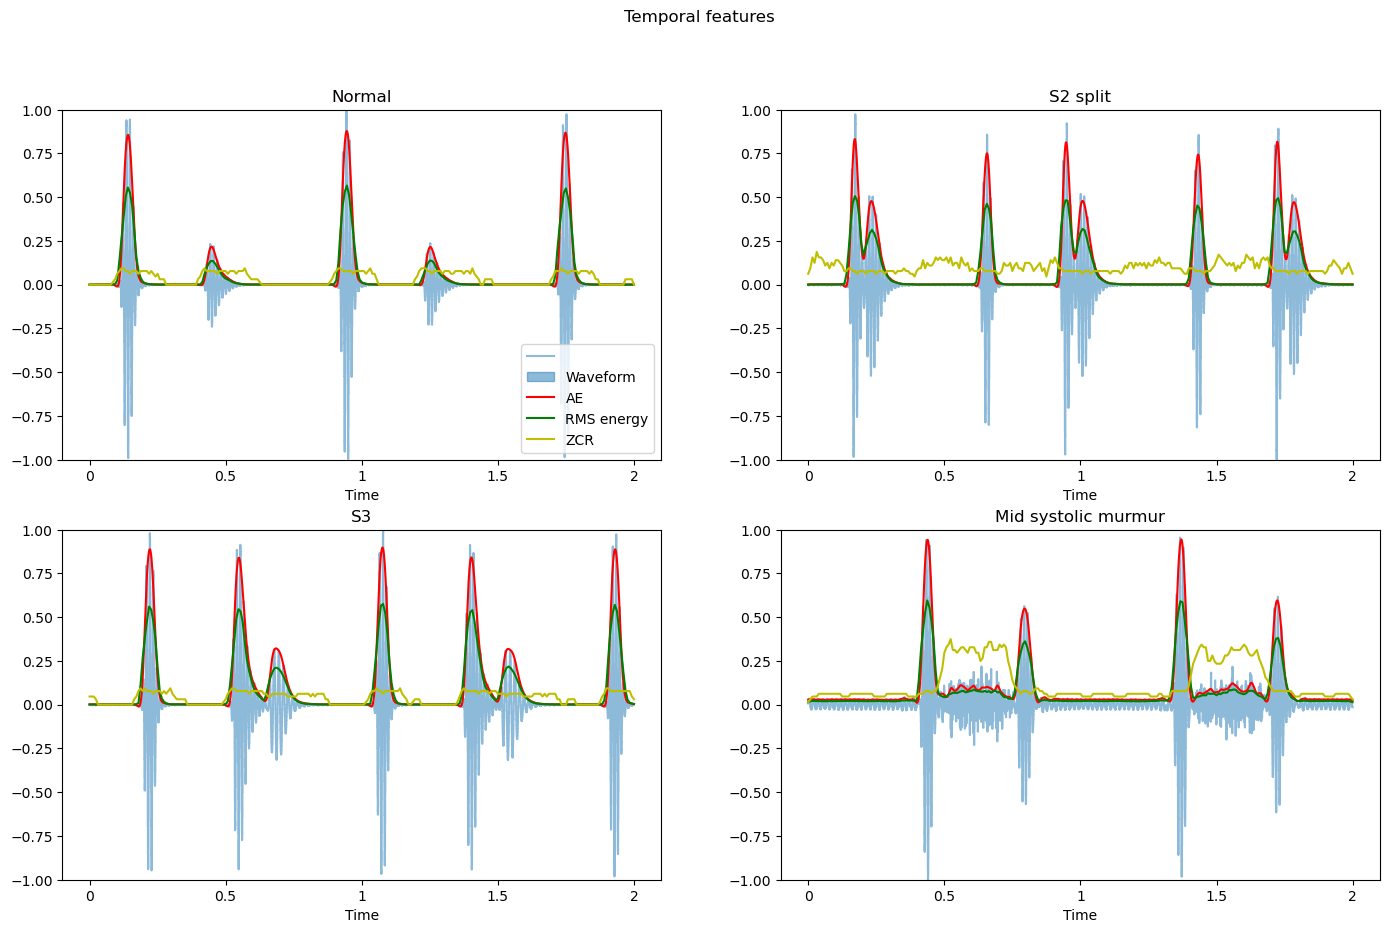

In [19]:
plt.figure(figsize=(17, 10))

plt.subplot(2, 2, 1)
librosa.display.waveshow(normal_resampled, sr=low_sr, alpha=0.5)
plt.plot(t_amp, aef_normal, color="r")
plt.plot(t, rms_normal, color="g")
plt.plot(t, zcr_normal, color="y")
plt.ylim((-1, 1))
plt.title("Normal")
plt.legend(["", "Waveform", "AE", "RMS energy", "ZCR"])

plt.subplot(2, 2, 2)
librosa.display.waveshow(s2_split_resampled, sr=low_sr, alpha=0.5)
plt.plot(t_amp, aef_s2_split, color="r")
plt.plot(t, rms_s2_split, color="g")
plt.plot(t, zcr_s2_split, color="y")
plt.ylim((-1, 1))
plt.title("S2 split")

plt.subplot(2, 2, 3)
librosa.display.waveshow(s3_resampled, sr=low_sr, alpha=0.5)
plt.plot(t_amp, aef_s3, color="r")
plt.plot(t, rms_s3, color="g")
plt.plot(t, zcr_s3, color="y")
plt.ylim((-1, 1))
plt.title("S3")

plt.subplot(2, 2, 4)
librosa.display.waveshow(mid_syst_murmur_resampled, sr=low_sr, alpha=0.5)
plt.plot(t_amp, aef_mid_syst_murmur, color="r")
plt.plot(t, rms_mid_syst_murmur, color="g")
plt.plot(t, zcr_mid_syst_murmur, color="y")
plt.ylim((-1, 1))
plt.title("Mid systolic murmur")

plt.suptitle("Temporal features")
plt.show()

## Frequency domain

We use FFT to compute the amplitude spectrum.

Note that FFT produces as many frequencies as input points (and that it is wise to use a power of 2).

In [20]:
# f_ratio is the ratio of frequency we want to display.
# Use 0.5 to stop at the Nyquist frequency.
f_ratio = 0.5

def amplitude_spectrum(signal):
    fft = np.fft.fft(signal)
    return np.abs(fft)

fft_normal = amplitude_spectrum(normal_resampled)
fft_s2_split = amplitude_spectrum(s2_split_resampled)
fft_s3 = amplitude_spectrum(s3_resampled)
fft_mid_syst_murmur = amplitude_spectrum(mid_syst_murmur_resampled)

# Frequency vector
frequencies = np.linspace(0, low_sr, len(fft_normal))

# Index cutoff
f_index_cutoff = int(len(fft_normal)*f_ratio)


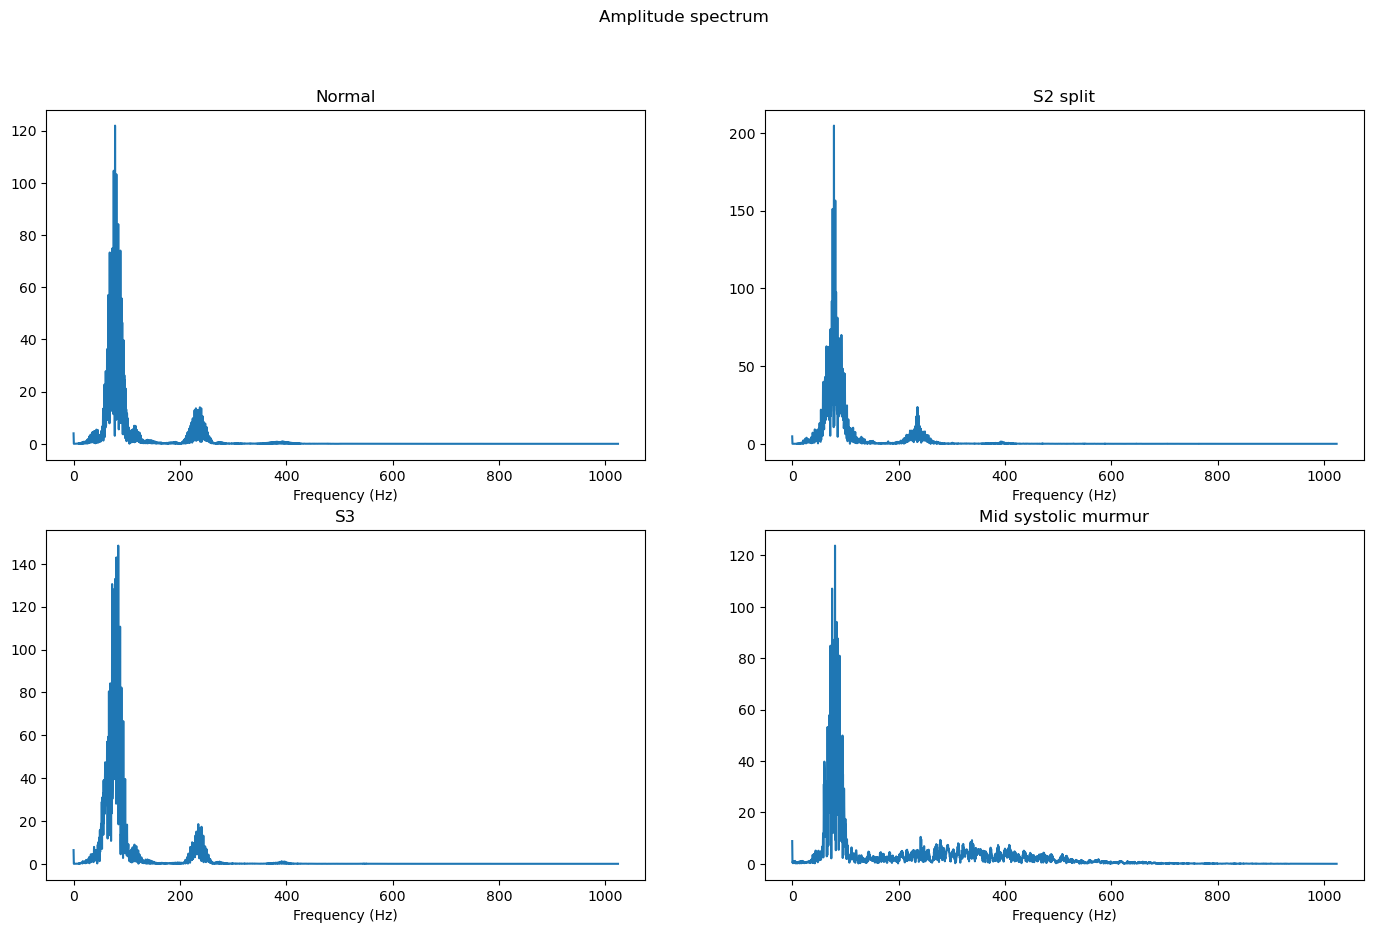

In [21]:
plt.figure(figsize=(17, 10))

plt.subplot(2, 2, 1)
plt.plot(frequencies[:f_index_cutoff], fft_normal[:f_index_cutoff])
plt.xlabel('Frequency (Hz)')
plt.title("Normal")

plt.subplot(2, 2, 2)
plt.plot(frequencies[:f_index_cutoff], fft_s2_split[:f_index_cutoff])
plt.xlabel('Frequency (Hz)')
plt.title("S2 split")

plt.subplot(2, 2, 3)
plt.plot(frequencies[:f_index_cutoff], fft_s3[:f_index_cutoff])
plt.xlabel('Frequency (Hz)')
plt.title("S3")

plt.subplot(2, 2, 4)
plt.plot(frequencies[:f_index_cutoff], fft_mid_syst_murmur[:f_index_cutoff])
plt.xlabel('Frequency (Hz)')
plt.title("Mid systolic murmur")

plt.suptitle("Amplitude spectrum")
plt.show()

We can also display the log-power spectrum:

In [22]:
fft_logpower_normal = librosa.power_to_db(fft_normal ** 2)
fft_logpower_s2_split = librosa.power_to_db(fft_s2_split ** 2)
fft_logpower_s3 = librosa.power_to_db(fft_s3 ** 2)
fft_logpower_mid_syst_murmur = librosa.power_to_db(fft_mid_syst_murmur **2)

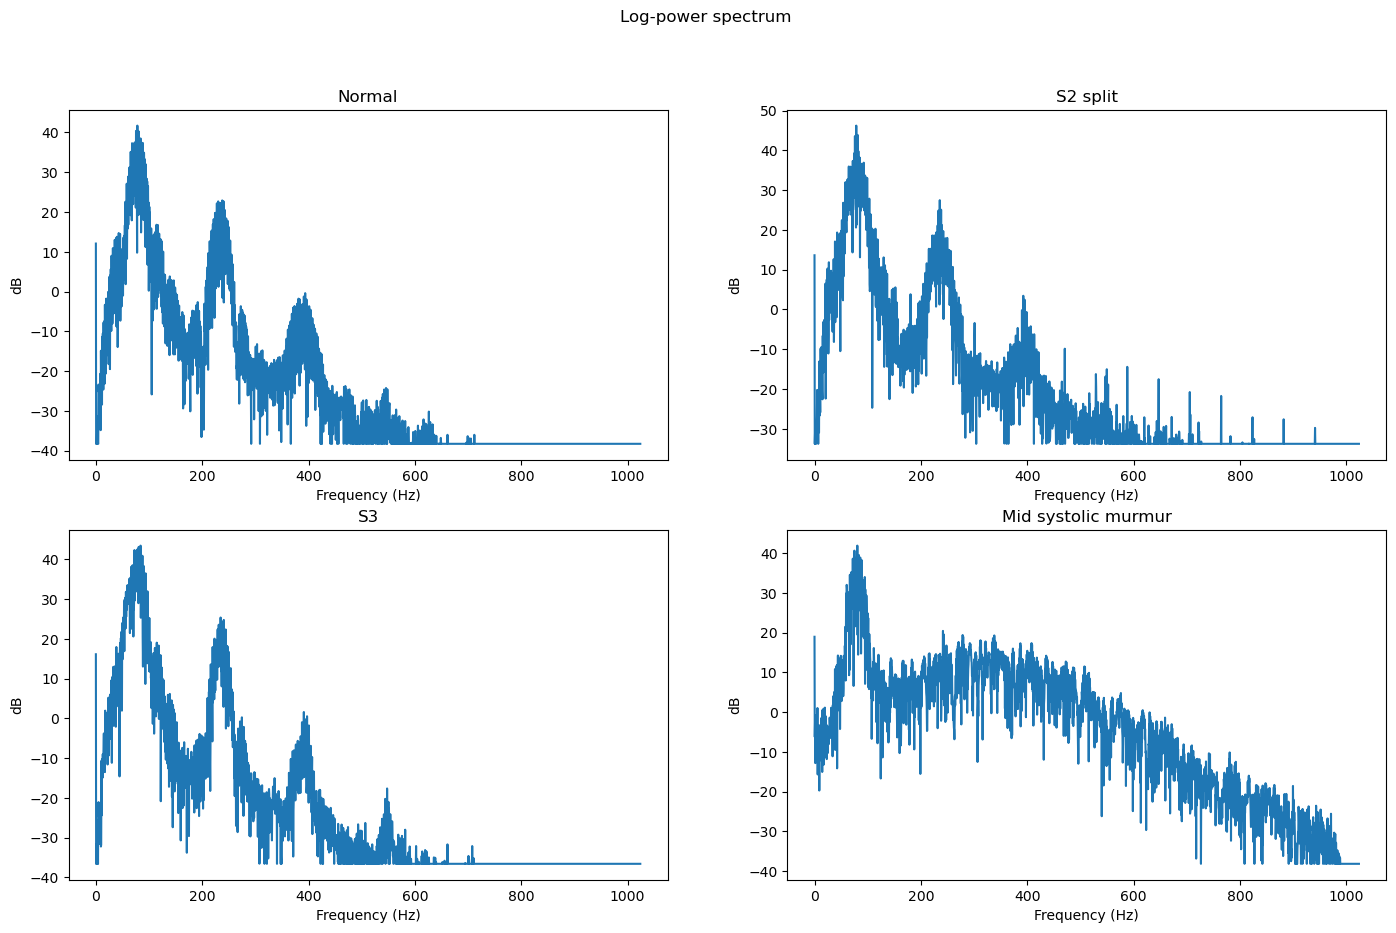

In [23]:
plt.figure(figsize=(17, 10))

plt.subplot(2, 2, 1)
plt.plot(frequencies[:f_index_cutoff], fft_logpower_normal[:f_index_cutoff])
plt.xlabel('Frequency (Hz)')
plt.ylabel('dB')
plt.title("Normal")

plt.subplot(2, 2, 2)
plt.plot(frequencies[:f_index_cutoff], fft_logpower_s2_split[:f_index_cutoff])
plt.xlabel('Frequency (Hz)')
plt.ylabel('dB')
plt.title("S2 split")

plt.subplot(2, 2, 3)
plt.plot(frequencies[:f_index_cutoff], fft_logpower_s3[:f_index_cutoff])
plt.xlabel('Frequency (Hz)')
plt.ylabel('dB')
plt.title("S3")

plt.subplot(2, 2, 4)
plt.plot(frequencies[:f_index_cutoff], fft_logpower_mid_syst_murmur[:f_index_cutoff])
plt.xlabel('Frequency (Hz)')
plt.ylabel('dB')
plt.title("Mid systolic murmur")

plt.suptitle("Log-power spectrum")
plt.show()

## Time-frequency domain

### Spectral centroid and bandwidth

- Spectral centroid: centre of gravity of mass of the spectrum (mean frequency).
- Spectral bandwidth: spread of a signal’s frequency content around its spectral centroid (equivalent of a standard deviation).

In [24]:
FRAME_SIZE = 2**6
HOP_LENGTH = 2**3

In [25]:
sc_normal = librosa.feature.spectral_centroid(y=normal_resampled, sr=low_sr, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
sc_s2_split = librosa.feature.spectral_centroid(y=s2_split_resampled, sr=low_sr, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
sc_s3 = librosa.feature.spectral_centroid(y=s3_resampled, sr=low_sr, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
sc_mid_syst_murmur = librosa.feature.spectral_centroid(y=mid_syst_murmur_resampled, sr=low_sr, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)[0]

sb_normal = librosa.feature.spectral_bandwidth(y=normal_resampled, sr=low_sr, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
sb_s2_split = librosa.feature.spectral_bandwidth(y=s2_split_resampled, sr=low_sr, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
sb_s3 = librosa.feature.spectral_bandwidth(y=s3_resampled, sr=low_sr, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
sb_mid_syst_murmur = librosa.feature.spectral_bandwidth(y=mid_syst_murmur_resampled, sr=low_sr, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)[0]

In [26]:
frames = range(len(sc_normal))
t = librosa.frames_to_time(frames, sr= low_sr, hop_length=HOP_LENGTH)

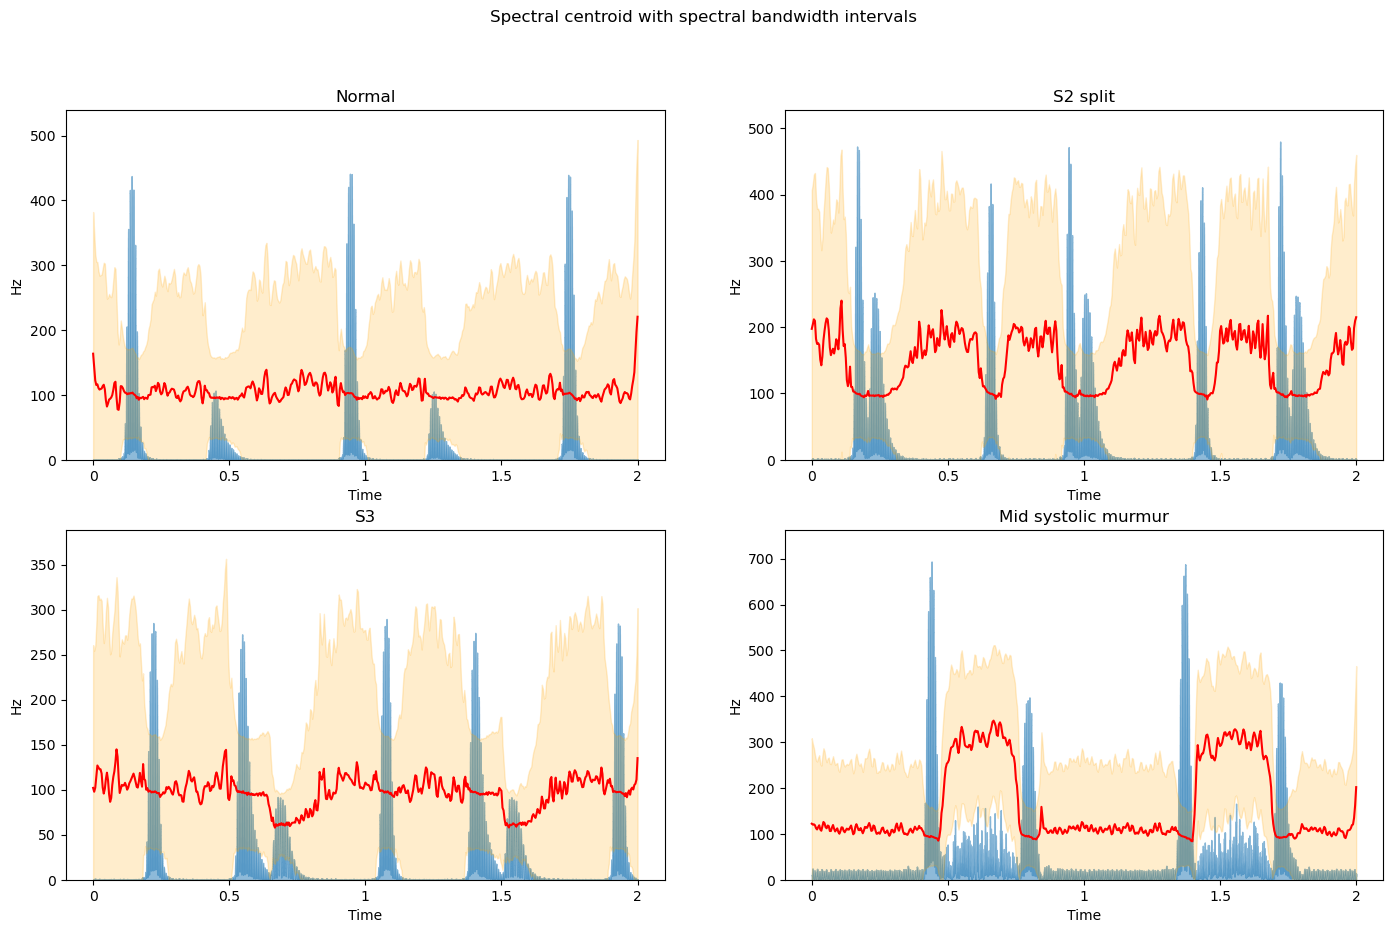

In [27]:
plt.figure(figsize=(17, 10))

plt.subplot(2, 2, 1)
librosa.display.waveshow(normal * max(sc_normal) * 2, alpha=0.5)
plt.plot(t, sc_normal, color="r")
plt.fill_between(t, sc_normal - sb_normal, sc_normal + sb_normal, color="orange", alpha=0.2)
plt.ylabel("Hz")
plt.ylim(0, None)
plt.title("Normal")

plt.subplot(2, 2, 2)
librosa.display.waveshow(s2_split * max(sc_s2_split) * 2, alpha=0.5)
plt.plot(t, sc_s2_split, color="r")
plt.fill_between(t, sc_s2_split - sb_s2_split, sc_s2_split + sb_s2_split, color="orange", alpha=0.2)
plt.ylabel("Hz")
plt.ylim(0, None)
plt.title("S2 split")

plt.subplot(2, 2, 3)
librosa.display.waveshow(s3 * max(sc_s3) * 2, alpha=0.5)
plt.plot(t, sc_s3, color="r")
plt.fill_between(t, sc_s3 - sb_s3, sc_s3 + sb_s3, color="orange", alpha=0.2)
plt.ylabel("Hz")
plt.ylim(0, None)
plt.title("S3")

plt.subplot(2, 2, 4)
librosa.display.waveshow(mid_syst_murmur * max(sc_mid_syst_murmur) * 2, alpha=0.5)
plt.plot(t, sc_mid_syst_murmur, color="r")
plt.fill_between(t, sc_mid_syst_murmur - sb_mid_syst_murmur, sc_mid_syst_murmur + sb_mid_syst_murmur, color="orange", alpha=0.2)
plt.ylabel("Hz")
plt.ylim(0, None)
plt.title("Mid systolic murmur")

plt.suptitle("Spectral centroid with spectral bandwidth intervals")
plt.show()

Let us visualize the spectral bandwidth separately:

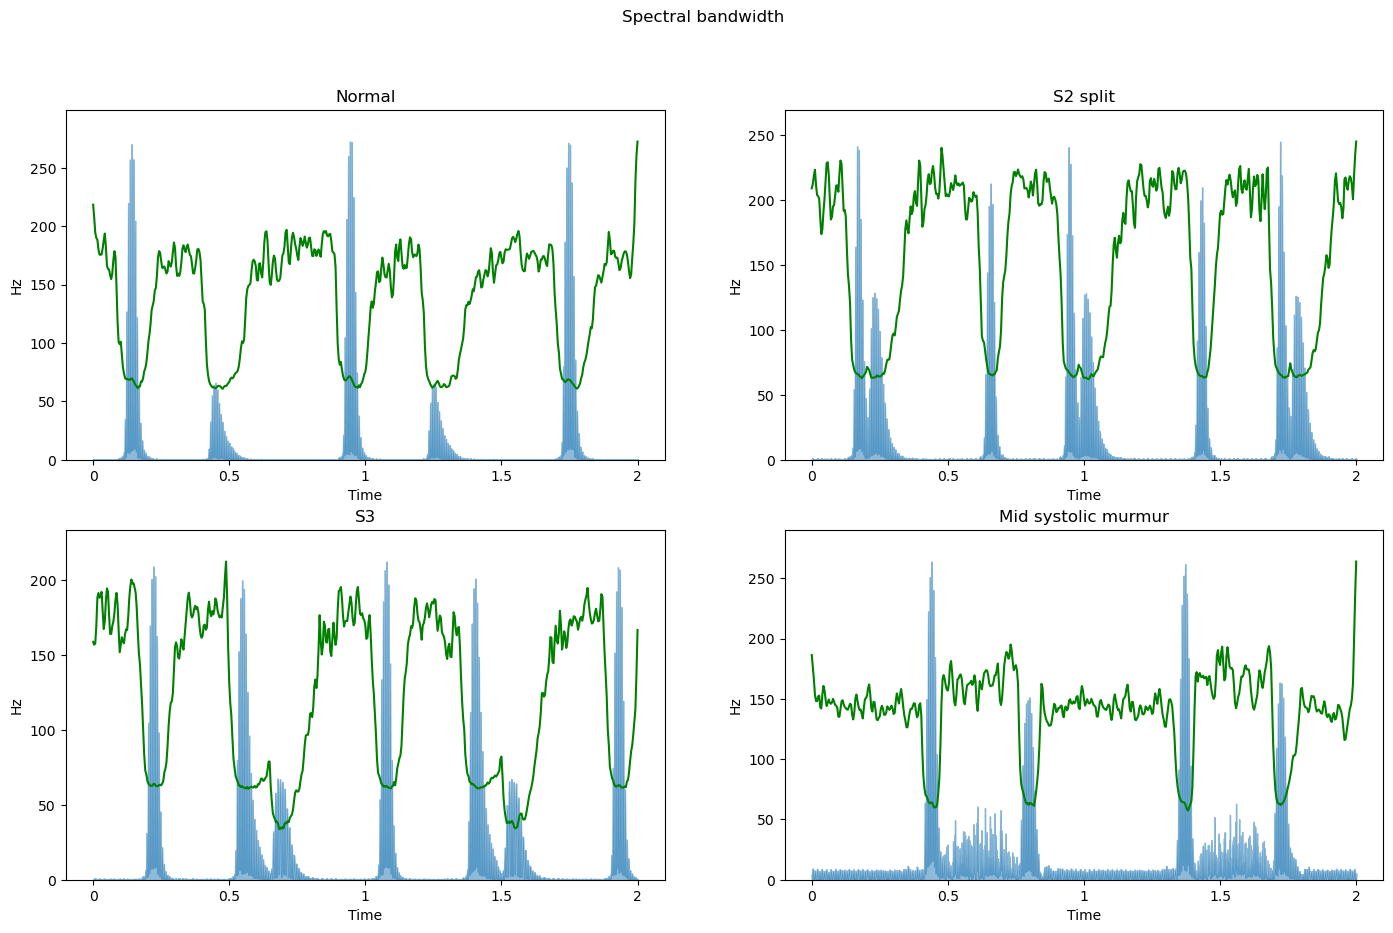

In [28]:
plt.figure(figsize=(17, 10))

plt.subplot(2, 2, 1)
librosa.display.waveshow(normal * max(sb_normal), alpha=0.5)
plt.plot(t, sb_normal, color="g")
plt.ylabel("Hz")
plt.ylim(0, None)
plt.title("Normal")

plt.subplot(2, 2, 2)
librosa.display.waveshow(s2_split * max(sb_s2_split), alpha=0.5)
plt.plot(t, sb_s2_split, color="g")
plt.ylabel("Hz")
plt.ylim(0, None)
plt.title("S2 split")

plt.subplot(2, 2, 3)
librosa.display.waveshow(s3 * max(sb_s3), alpha=0.5)
plt.plot(t, sb_s3, color="g")
plt.ylabel("Hz")
plt.ylim(0, None)
plt.title("S3")

plt.subplot(2, 2, 4)
librosa.display.waveshow(mid_syst_murmur * max(sb_mid_syst_murmur), alpha=0.5)
plt.plot(t, sb_mid_syst_murmur, color="g")
plt.ylabel("Hz")
plt.ylim(0, None)
plt.title("Mid systolic murmur")

plt.suptitle("Spectral bandwidth")
plt.show()

### Spectrograms

We plot varius spectrograms:
- STFT
- Mel spectrogram
- MFCC

Notes about STFT:
- By default, window size == n_fft == FRAME_SIZE
- The default is a centered Hann window (zero padding)
- Because the number of frequency bins is equal to the frame size (+1), there is a **time-frequency localization trade-off**: smaller frame size improves the temporal resolution of the STFT (i.e. the ability to discriminate impulses that are closely spaced in time) at the expense of frequency resolution (i.e. the ability to discriminate pure tones that are closely spaced in frequency).

In [29]:
# Attention: when used as n_fft in stft, FRAME_SIZE must be a power of 2
#FRAME_SIZE = 2**6 # 64 samples. Corresponds to ~32ms at 2kHz
FRAME_SIZE = 2**5 # 32 samples. Corresponds to ~16ms at 2kHz
#HOP_LENGTH = 2**3 # 8 samples. Corresponds to ~4ms at 2kHz
#HOP_LENGTH = 2**2 # 4 samples. Corresponds to ~2ms at 2kHz
HOP_LENGTH = 2**1 # 2 samples. Corresponds to ~1ms at 2kHz
N_MFCC = 13

In [30]:
def plot_spectrograms(data, title, rate):
    # Compute STFT
    stft = librosa.stft(data, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)
    stft_power = np.abs(stft) ** 2
    stft_logpower = librosa.power_to_db(stft_power)

    # Compute Mel spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=data, sr=rate, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH, n_mels=N_MFCC)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Compute MFCC
    # Given we use the Mel spectrogram as inputs, it makes sense to use the same number of output bins in both functions.
    mfccs = librosa.feature.mfcc(S=librosa.power_to_db(mel_spectrogram), n_mfcc=N_MFCC, sr=rate)


    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, figsize=(17, 10), gridspec_kw={'height_ratios': [1, 5, 5, 5]})
    librosa.display.waveshow(data, sr=rate, ax=ax1)
    ax1.set_title("Waveform", rotation=270, x=1.05, y=0.3)
    img = librosa.display.specshow(stft_logpower,
                             sr=rate,
                             hop_length=HOP_LENGTH,
                             x_axis="time",
                             y_axis="log",
                             cmap='inferno',
                             ax=ax2)
    #fig.colorbar(img, ax=ax2, format='%+2.0f dB')
    ax2.set_title("Log-power spectrogram", rotation=270, x=1.05, y=0.3)

    librosa.display.specshow(log_mel_spectrogram,
                             sr=rate,
                             hop_length=HOP_LENGTH,
                             x_axis="time",
                             y_axis="mel",
                             cmap='inferno',
                             ax=ax3)
    ax3.set_title("Mel spectrogram", rotation=270, x=1.05, y=0.2)

    librosa.display.specshow(mfccs,
                             sr=rate,
                             hop_length=HOP_LENGTH,
                             x_axis="time",
                             y_axis="mel",
                             cmap='inferno',
                             ax=ax4)
    ax4.set_title("MFCC", rotation=270, x=1.05, y=0.5)
    fig.suptitle(title)

    plt.show()

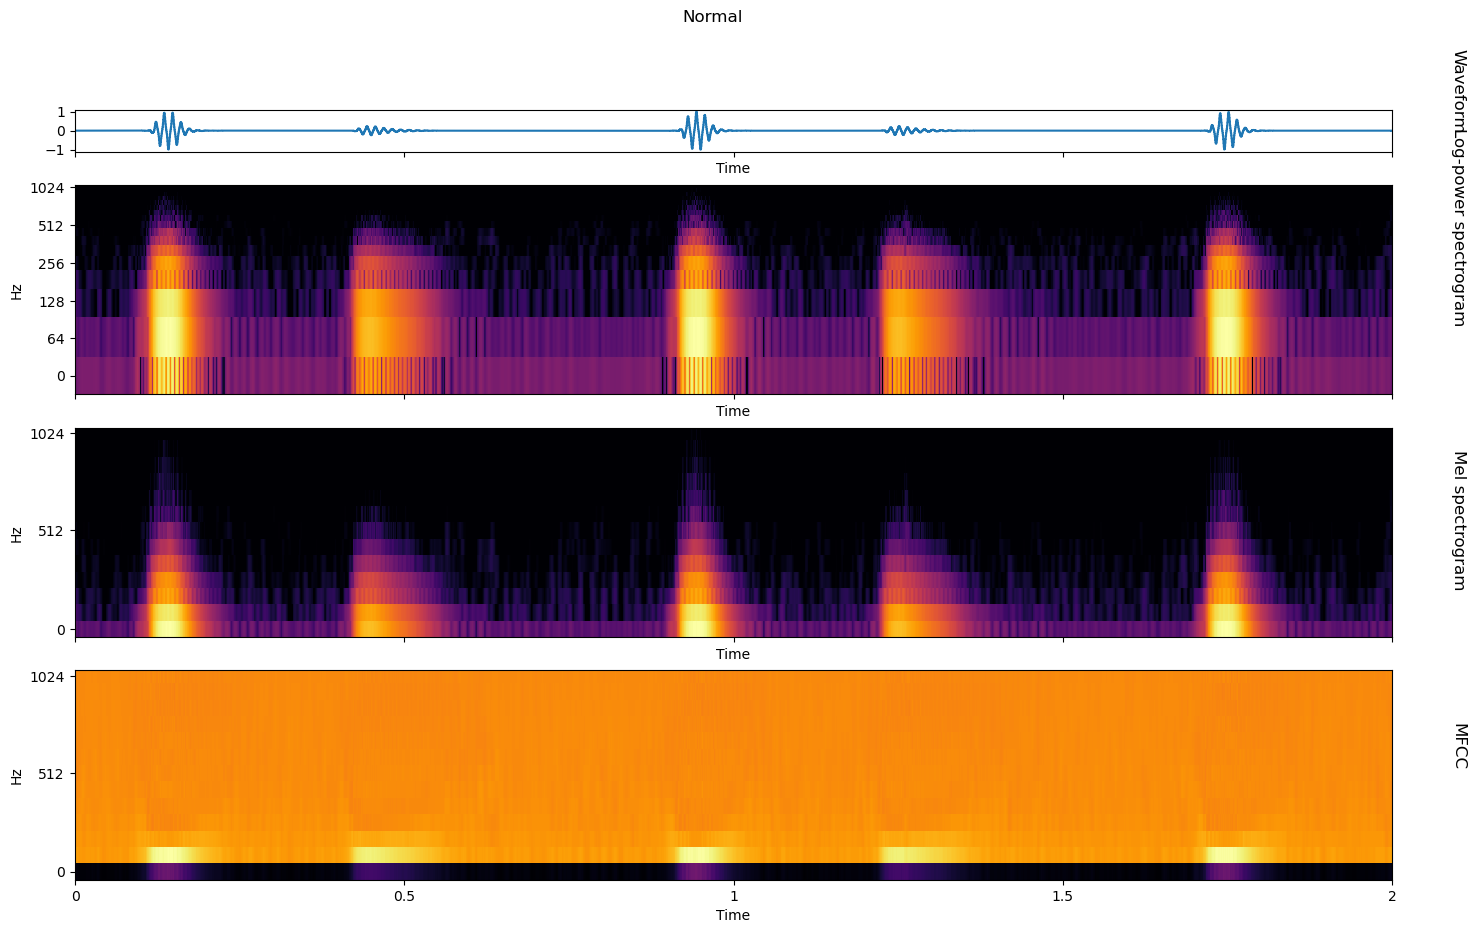

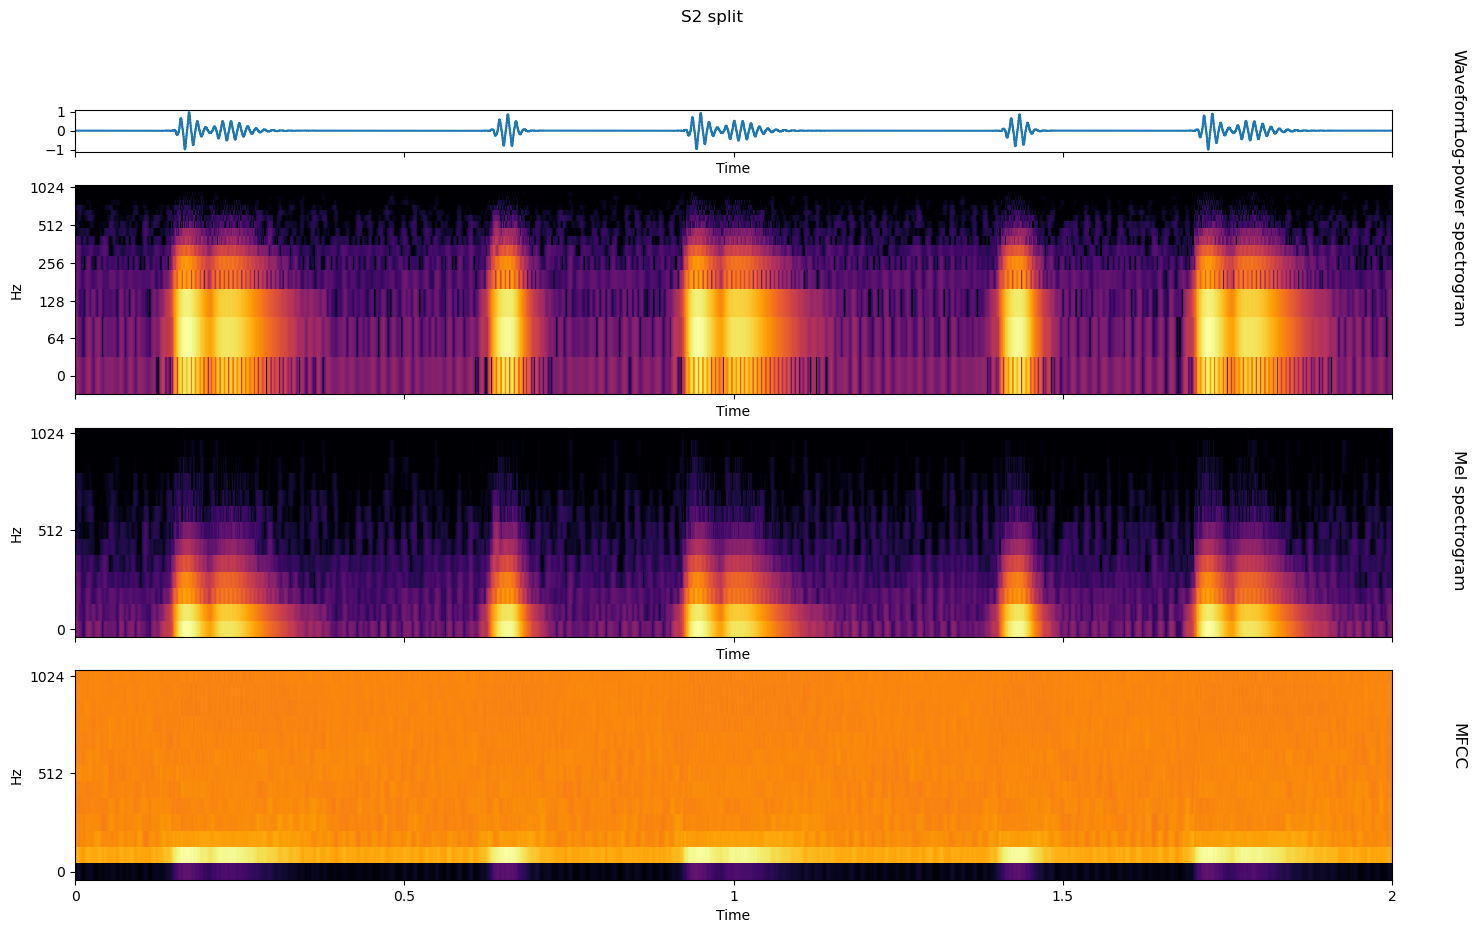

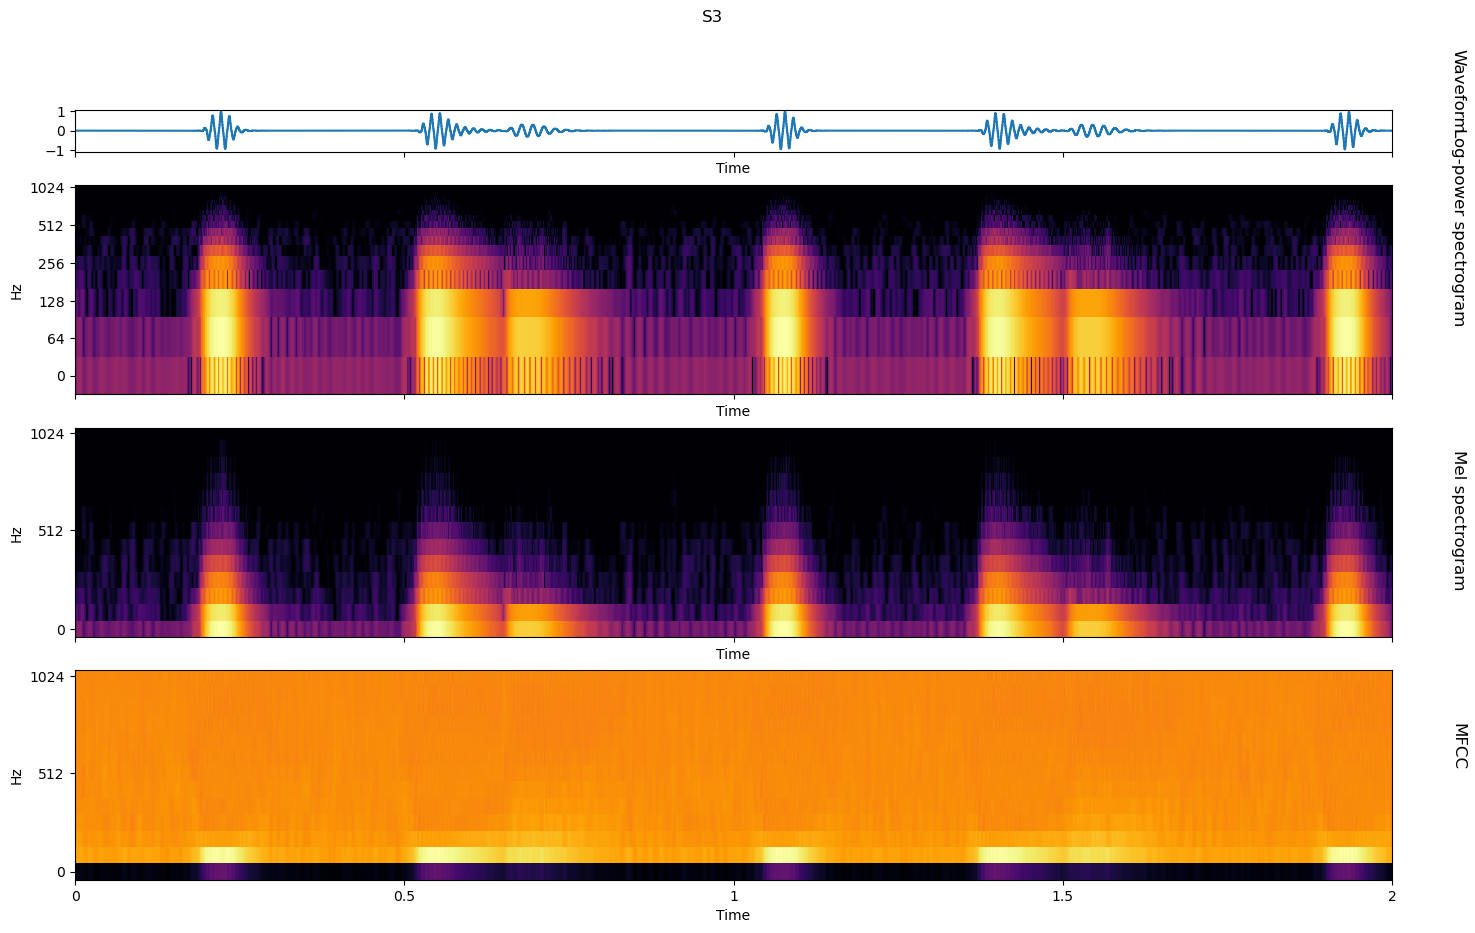

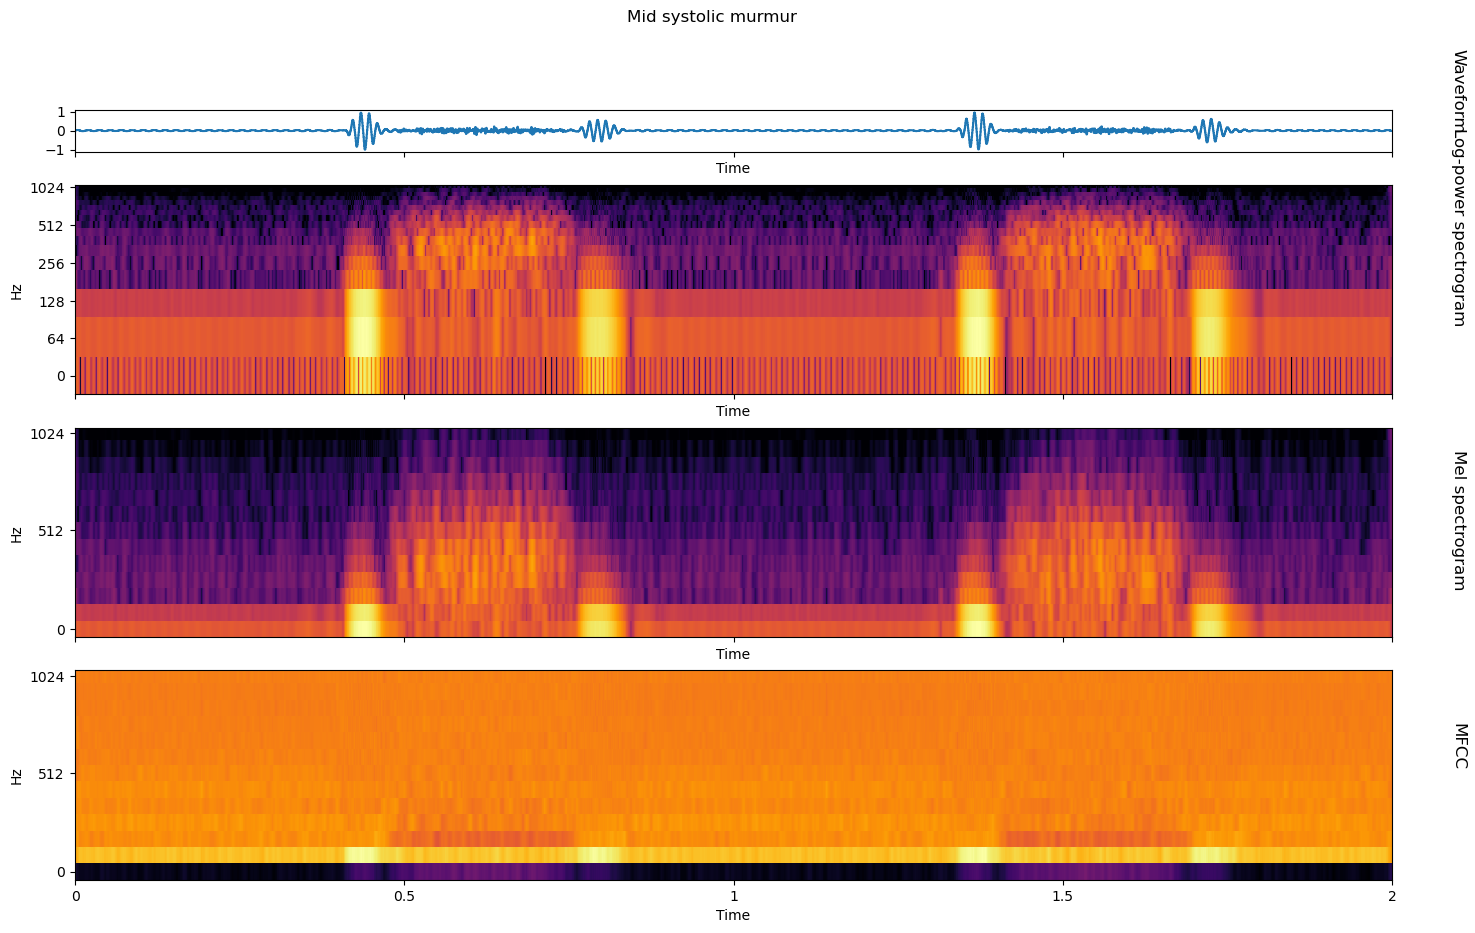

In [31]:
plot_spectrograms(normal_resampled, "Normal", low_sr)
plot_spectrograms(s2_split_resampled, "S2 split", low_sr)
plot_spectrograms(s3_resampled, "S3", low_sr)
plot_spectrograms(mid_syst_murmur_resampled, "Mid systolic murmur", low_sr)

Observations:
- The temporal resolution (frame size) was sufficient for making the S2 split clearly visible.
- The systolic murmur is easily identifiable despite a much larger steady noise level than in other recordings.

### Reassigned spectrogram

In a reassigned spectrogram, the time and frequency bins are changing to adapt to sudden changes in the signal.
This prevents an event to be smeared over several bins boundaries.

In [38]:
# Compute the reassigned spectrogram

def spectogram_reassigned_spectogram(signal, rate):
    freqs, times, mags = librosa.reassigned_spectrogram(y=signal, sr=rate, hop_length=HOP_LENGTH, n_fft=FRAME_SIZE, center=False)
    mags_db = librosa.amplitude_to_db(mags, ref=np.max)
    fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(17, 10))
    img = librosa.display.specshow(mags_db, x_axis="s", y_axis="linear", sr=rate,
                             hop_length=HOP_LENGTH, ax=ax[0])
    ax[0].set(title="Spectrogram", xlabel=None)
    ax[0].label_outer()
    ax[1].scatter(times, freqs, c=mags_db, cmap="magma", alpha=0.5, s=5)
    ax[1].set_title("Reassigned spectrogram")
    ax[1].set_xlabel("Time (s)")
    ax[1].set_ylabel("Instantaneous frequency (Hz)")
    fig.colorbar(img, ax=ax, format="%+2.f dB")
    plt.show()

#### Normal S1 S2

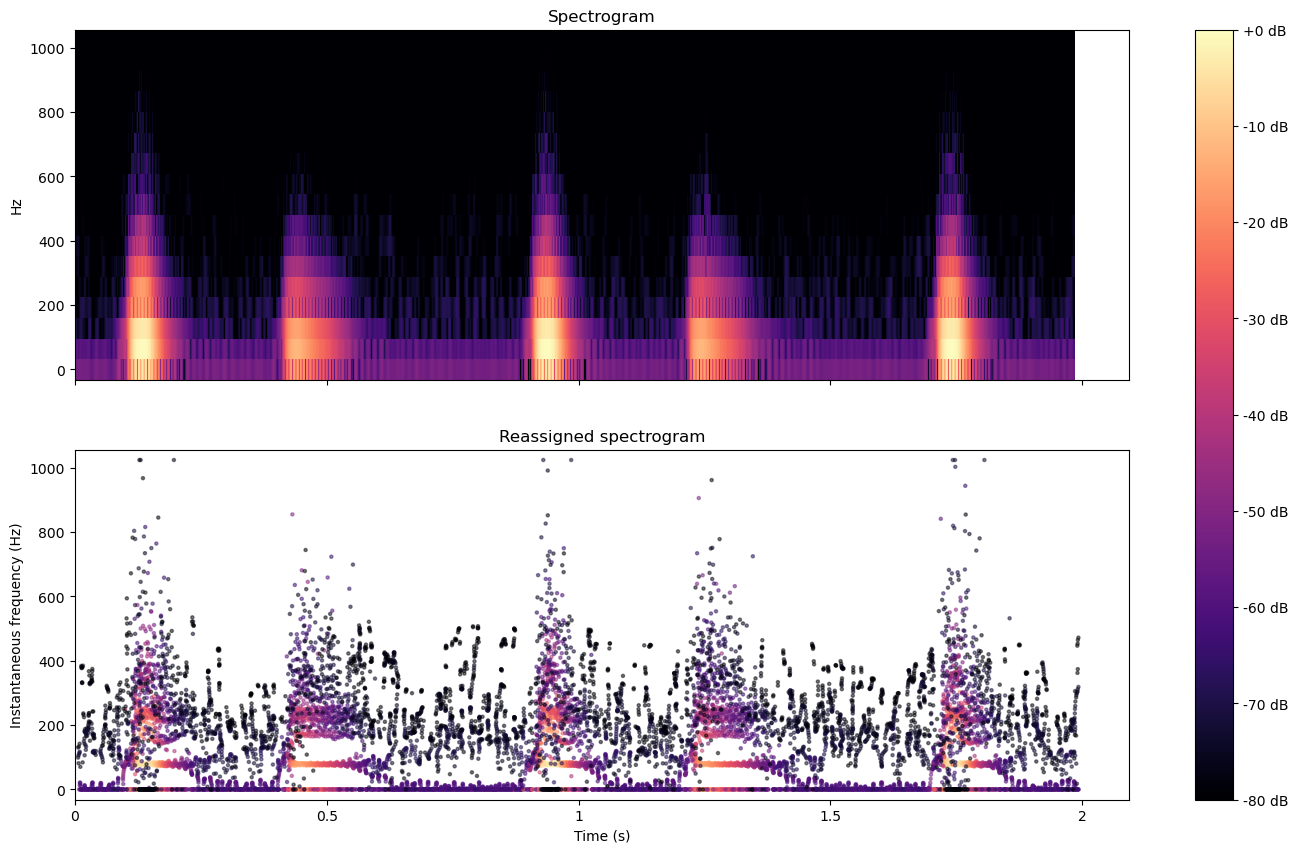

In [39]:
spectogram_reassigned_spectogram(normal_resampled, low_sr)

We can clearly see that the reassigned spectrogram contains much finer details (frequency axis). The horizontal lines are the heart sounds with their harmonics.

#### Split S2


The plot below shows that it is much more difficult to recognize an S2 split in the reassigned spectrogram:

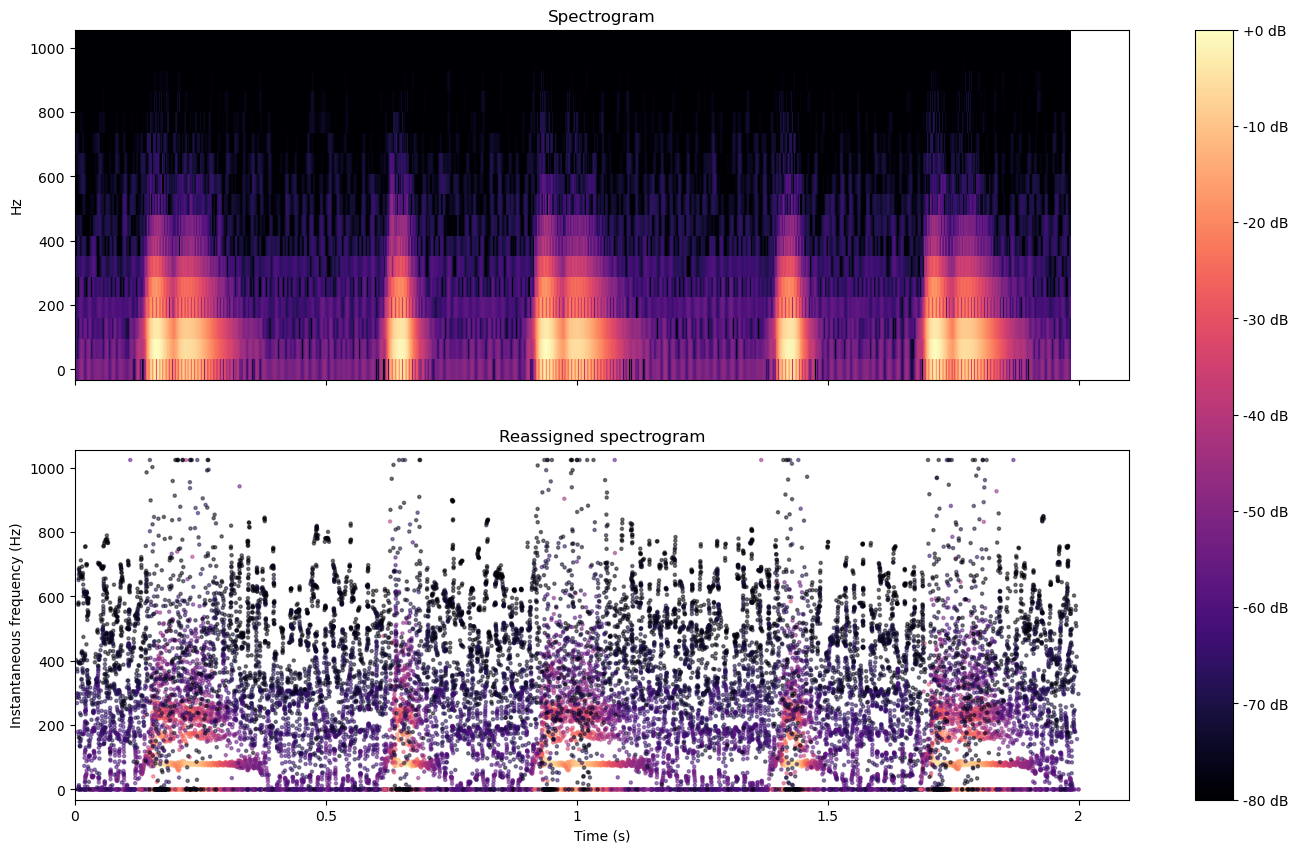

In [33]:
spectogram_reassigned_spectogram(s2_split_resampled, low_sr)

#### S3

S3 sounds are visible with their lower pitch than S1 and S2:

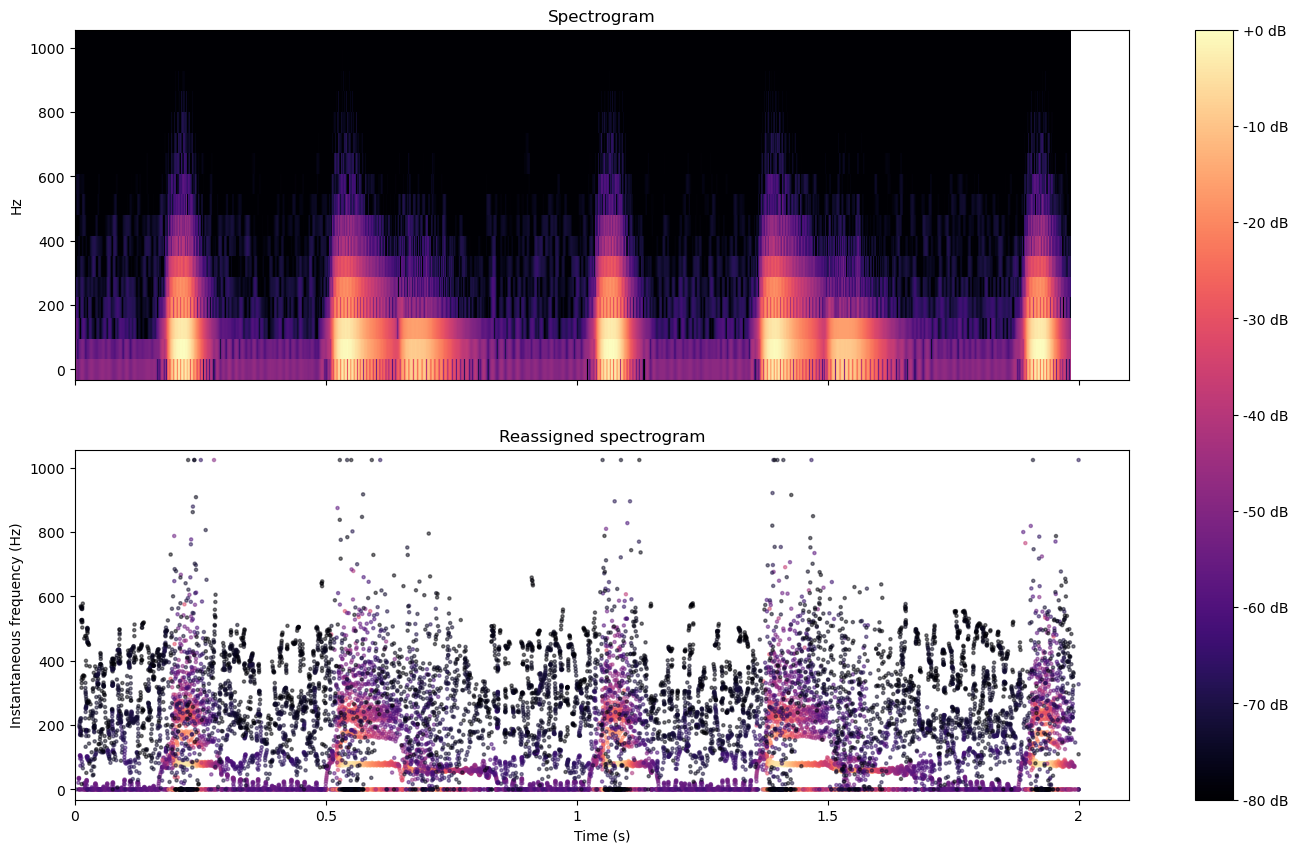

In [34]:
spectogram_reassigned_spectogram(s3_resampled, low_sr)

#### Mid systolic click

The click is easily identifiable due to the lack of horizontal 60 Hz fundamental frequency:

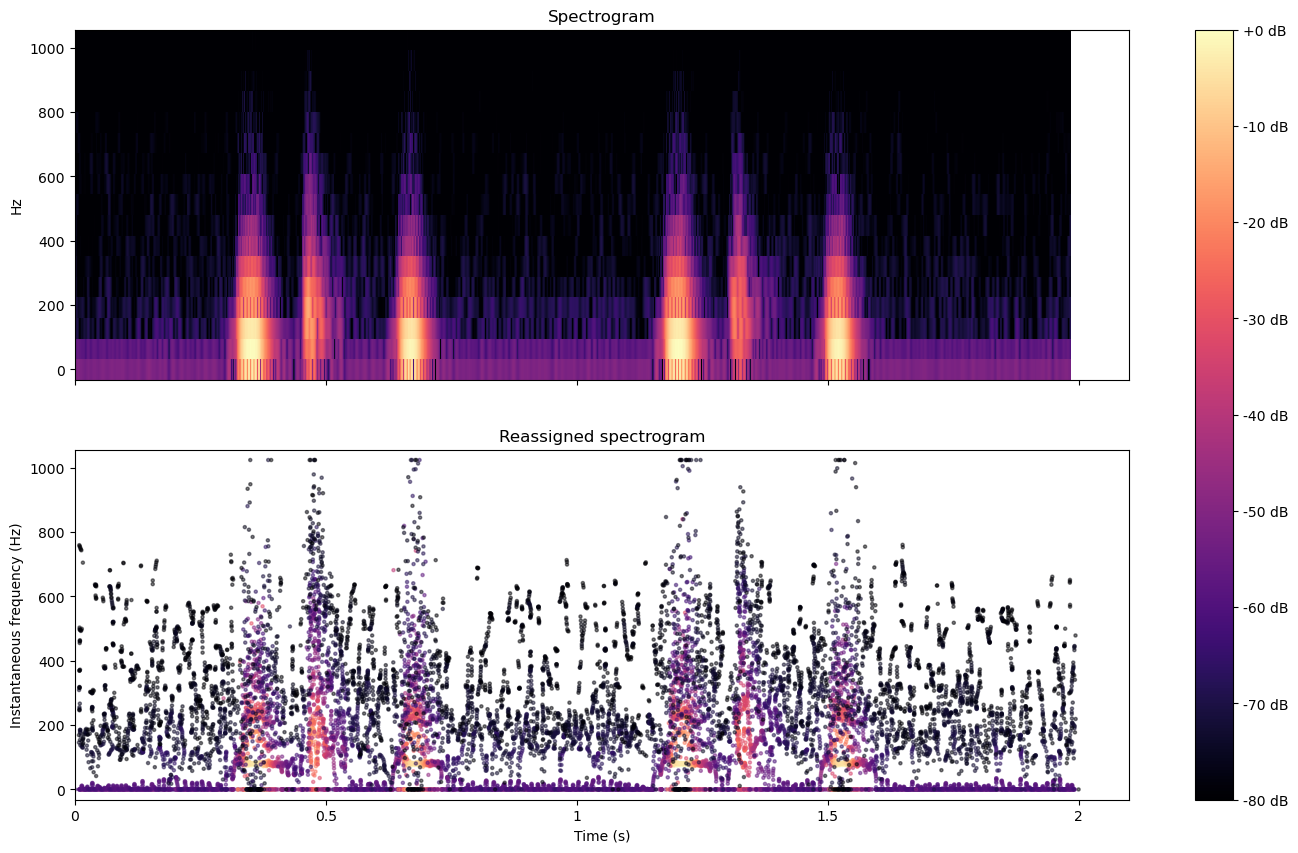

In [40]:
spectogram_reassigned_spectogram(mid_syst_click_resampled, low_sr)

#### Mid systolic murmur

The murmur is also clearly visible:

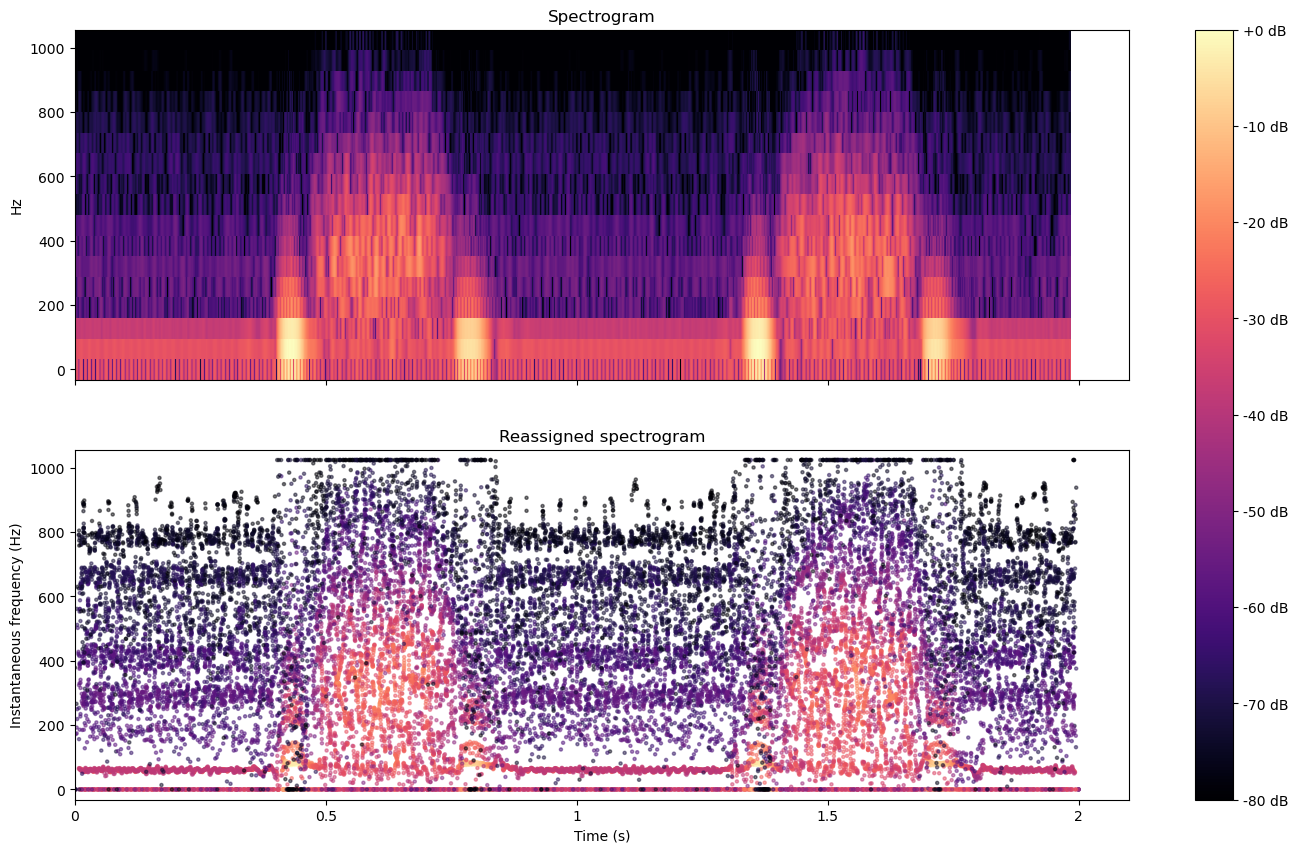

In [35]:
spectogram_reassigned_spectogram(mid_syst_murmur_resampled, low_sr)